# Preprocessing and Data Visualization

In this project, our goal is to develop a system for information retrieval in a collection of film descriptions published on Allociné. Specifically, we will focus on automatically classifying films by their genre based on the text of their synopsis and title.

## Problem Understanding

The project involves developing a system for information retrieval in a collection of film descriptions from Allociné. The project is divided into two steps, with the first step focusing on training an automated film genre classification tool based on the synopsis and title of the films. The training will be conducted using two CSV files of French-language film descriptions provided on Moodle. Different classification algorithms and text features will be compared and evaluated using best practices such as cross-validation. The second step will involve applying the selected model to a new dataset and producing labeled data with predicted genres.

## Data Understanding

The data is provided in two CSV files, one for training and one for testing. The training data contains 2875 films with the following 22 fields:

- acteur_1
- acteur_2
- acteur_3
- allocine_id
- annee_prod
- annee_sortie
- box_office_fr
- couleur
- duree
- langues
- nationalite
- nb_critiques_presse
- nb_critique_spectateurs
- nb_notes_spectateurs
- note_presse
- note_spectateurs
- realisateurs
- synopsis
- type_film
- genre

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import plotly.graph_objs as go
import string 
import nltk
nltk.download('stopwords')
import nlp
import spacy



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elmah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\elmah\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Read the data


In [3]:
df = pd.read_csv('../data/allocine_genres_train.csv')

df.head()

,Unnamed: 0,acteur_1,acteur_2,acteur_3,allocine_id,annee_prod,annee_sortie,box_office_fr,couleur,duree,...,nb_critiques_presse,nb_critiques_spectateurs,nb_notes_spectateurs,note_presse,note_spectateurs,realisateurs,synopsis,titre,type_film,genre
0,4772,Albert Finney,Lauren Bacall,Jacqueline Bisset,1453,1974,1975.0,549055.0,Couleur,128.0,...,NaN,125.0,2045.0,NaN,3.7,Sidney Lumet,"En visite à Istanbul , le célèbre détective be...",Le Crime de l' Orient - Express,NaN,policier
1,335,Henry Fonda,Martin Balsam,John Fiedler,4063,1957,1957.0,NaN,NaN,95.0,...,7.0,771.0,18670.0,5.0,4.6,Sidney Lumet,Un jeune homme d' origine modeste est accusé d...,12 hommes en colère,NaN,drame
2,4860,Alexandra Lamy,Michaël Abiteboul,Julia Piaton,241952,2016,2019.0,NaN,Couleur,90.0,...,NaN,22.0,242.0,NaN,4.2,Nicolas Cuche,"Lorsque Marie-Laure , mère de quatre jeunes en...",Après moi le bonheur,Télefilm,drame
3,1913,Charles Chaplin,Virginia Cherrill,Harry Myers,2256,1931,1931.0,NaN,NaN,87.0,...,4.0,190.0,6185.0,4.5,4.4,Charles Chaplin,Un vagabond s’ éprend d’ une belle et jeune ve...,Les Lumières de la ville,NaN,romance
4,3726,Robert De Niro,Cuba Gooding Jr.,Charlize Theron,27434,2000,2001.0,221677.0,Couleur,129.0,...,17.0,104.0,1619.0,2.4,3.6,George Tillman Jr.,"L' histoire vraie de Carl Brashear , premier A...",Les Chemins de la dignité,Long-métrage,biopic


In [4]:
# check the size of the dataset and the type of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2875 entries, 0 to 2874
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                2875 non-null   int64  
 1   acteur_1                  2875 non-null   object 
 2   acteur_2                  2748 non-null   object 
 3   acteur_3                  2733 non-null   object 
 4   allocine_id               2875 non-null   int64  
 5   annee_prod                2875 non-null   int64  
 6   annee_sortie              2690 non-null   float64
 7   box_office_fr             1783 non-null   float64
 8   couleur                   2708 non-null   object 
 9   duree                     2828 non-null   float64
 10  langues                   2426 non-null   object 
 11  nationalite               2875 non-null   object 
 12  nb_critiques_presse       2020 non-null   float64
 13  nb_critiques_spectateurs  2758 non-null   float64
 14  nb_notes

In [5]:
# drop the first column
df.drop(df.columns[0], axis=1, inplace=True)

# check the percentage of missing values as an int 
df.isnull().sum() / df.shape[0] * 100


acteur_1                     0.000000
acteur_2                     4.417391
acteur_3                     4.939130
allocine_id                  0.000000
annee_prod                   0.000000
annee_sortie                 6.434783
box_office_fr               37.982609
couleur                      5.808696
duree                        1.634783
langues                     15.617391
nationalite                  0.000000
nb_critiques_presse         29.739130
nb_critiques_spectateurs     4.069565
nb_notes_spectateurs         3.130435
note_presse                 28.730435
note_spectateurs             3.026087
realisateurs                 0.000000
synopsis                     0.000000
titre                        0.000000
type_film                   22.956522
genre                        0.000000
dtype: float64

We're lucky that the columns we're gonna use have 0 missing values. We can see that the columns `titre`, `genre`, and `synopsis` have a no missing values. We will drop these columns.

In [6]:
# drop columns but keep synopsis, title and genres and create the dataframe we will use
df_use = df.loc[:, ['synopsis', 'titre', 'genre']]

df_use.describe()

,synopsis,titre,genre
count,2875,2875,2875
unique,2875,2846,9
top,"En visite à Istanbul , le célèbre détective be...",Le Crime de l' Orient - Express,drame
freq,1,2,501


drame              501
comédie            483
romance            443
policier           331
horreur            299
science fiction    298
biopic             191
documentaire       167
historique         162
Name: genre, dtype: int64


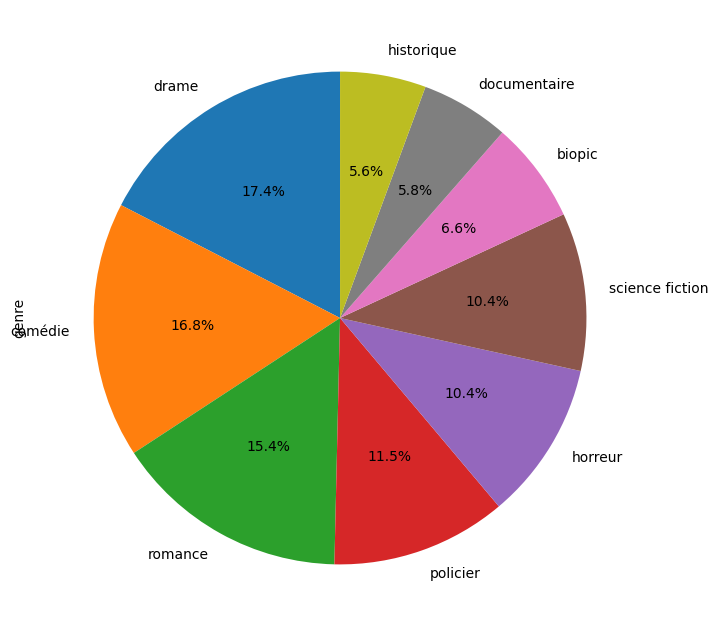

In [7]:
# show the movies that have a genre that appears only once
print(df_use['genre'].value_counts())

plt.figure(figsize=(12, 8))
df_use['genre'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.show()

We can see that the most common genre are `drame`, `comédie` and `romance`. It also appears that there is no genre that is very rare, which is great as we will be able to train our model on all the genres. 

In [8]:
# look for duplicates
df_use.duplicated().sum()

0

In [9]:
df_use.head()

,synopsis,titre,genre
0,"En visite à Istanbul , le célèbre détective be...",Le Crime de l' Orient - Express,policier
1,Un jeune homme d' origine modeste est accusé d...,12 hommes en colère,drame
2,"Lorsque Marie-Laure , mère de quatre jeunes en...",Après moi le bonheur,drame
3,Un vagabond s’ éprend d’ une belle et jeune ve...,Les Lumières de la ville,romance
4,"L' histoire vraie de Carl Brashear , premier A...",Les Chemins de la dignité,biopic


Now that we have cleaned our dataset a little bit, let's work on the synopsis and the title.

## Cleaning the `title` column

We will start with the `title` column. We will first convert the text to lowercase and remove the punctuation and special characters.

Now we will do what we call NER, which stands for Named Entity Recognition. We will use the `spacy` library to do that. We will use the `fr_core_news_sm` model. We will also use the `displacy` library to visualize the results.


We're gonna create another dataset where we will delete the NER tags to test it later.

In [10]:



def return_NER(sentence):
    nlp = spacy.load('fr_core_news_sm')
    doc = nlp(sentence)
    return [(X.text, X.label_) for X in doc.ents]

# create a new column with the NER_title
df_use['NER_title'] = df_use['titre'].apply(lambda x: return_NER(x))



In [11]:


def remove_NER(df_use,col):
    if col == 'title':
        df_use['NER_title'] = df_use['titre'].apply(lambda x: return_NER(x))

        # Iterate through each row
        for i, row in df_use.iterrows():
            ners = row['NER_title']
    
            for ner in ners:
                entity, tag = ner
                row['titre'] = row['titre'].replace(entity, '')
    if col == 'synopsis':
        df_use['NER_synopsis'] = df_use['synopsis'].apply(lambda x: return_NER(x))

        # Iterate through each row
        for i, row in df_use.iterrows():
            ners = row['NER_synopsis']
    
            for ner in ners:
                entity, tag = ner
                row['synopsis'] = row['synopsis'].replace(entity, '')
                
                
remove_NER(df_use,'title')

In [12]:
# convert the title to lowercase
df_use['titre'] = df_use['titre'].str.lower()

df_use.titre.head()

0                        
1     12 hommes en colère
2    après moi le bonheur
3                        
4                    les 
Name: titre, dtype: object

Now we remove punctuation and special characters. We will also remove the stopwords. We will use the `nltk` library to do that.

In [13]:
# replace the character - with a space
df_use['titre'] = df_use['titre'].str.replace('-', ' ')
# replace the character ' with a space
df_use['titre'] = df_use['titre'].str.replace("'", ' ')


translator = str.maketrans('', '', string.punctuation)
df_use['titre'] = df_use['titre'].apply(lambda x: x.translate(translator))

df_use.titre.head(5)

0                        
1     12 hommes en colère
2    après moi le bonheur
3                        
4                    les 
Name: titre, dtype: object

We made sure to replace `-` and `'` with a space so that we don't lose the meaning of the words.

In [14]:

# create a new column for tokenized title
df_use['tokenized_title'] = df_use['titre'].apply(lambda x: x.split())

# remove the stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('french')
print(stop_words)

df_use['tokenized_title'] = df_use['tokenized_title'].apply(lambda x: [item for item in x if item not in stop_words])

# remove numbers
df_use['tokenized_title'] = df_use['tokenized_title'].apply(lambda x: [item for item in x if not item.isdigit()])


['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

Now we're gonna do stemming. We will use the `nltk` library to do that. We will use the `FrenchStemmer` class.

In [15]:
# stem the words
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()
df_use['tokenized_title'] = df_use['tokenized_title'].apply(lambda x: [stemmer.stem(item) for item in x])


# list the most common words in the tokenized title
from collections import Counter

words = []
for i in df_use['tokenized_title']:
    words.extend(i)
    
Counter(words).most_common(20)

[('a', 28),
 ('the', 27),
 ('tout', 24),
 ('vi', 22),
 ('homm', 21),
 ('jour', 21),
 ('deux', 17),
 ('comm', 16),
 ('amour', 16),
 ('femm', 16),
 ('si', 15),
 ('an', 14),
 ('nuit', 14),
 ('autr', 12),
 ('mond', 12),
 ('plus', 11),
 ('of', 11),
 ('chapitr', 11),
 ('san', 10),
 ('tous', 10)]

Let's add a custom list of stopwords

In [16]:
custom_stopwords = ["the", "a", "an", "and", "or", "of", "to", 
                    "in", "for", "on", "with", "at", "by", 
                    "from", "as", "into", "like", "through", 
                    "after", "over", "between", "out", "against",
                    "during", "without", "before", "under", 
                    "around", "among", "throughout", "des", 
                    "du", "de", "la", "le", "les", "un", 
                    "une", "et", "ou", "pour", "dans", 
                    "sur", "par", "avec", "à", "en", "au",
                    "aux", "du", "des", "de", "la", "le", 
                    "les", "un", "une", "et", "ou", "pour", 
                    "dans", "sur", "par", "avec", "à", "en", 
                    "au", "aux", "du", "des", "de", "la", "le", 
                    "les", "un", "une", "et", "ou", "pour", "dans",
                    "sur", "par", "avec", "à", "en", "au", "aux", 
                    "du", "des", "de", "la", "le", "les", "un", 
                    "une", "et", "ou", "pour", "dans", "sur", 
                    "par", "avec", "à", "en", "au", "aux", "du", 
                    "des", "de", "la", "le", "les", "un", "une", 
                    "et", "ou", "pour", "dans", "sur", "par", "avec",
                    "à", "en", "au", "aux", "du", "des", "de", "la",
                    "le", "les", "un", "une", "et", "ou", "pour", 
                    "dans", "sur", "par", "avec", "à", "en", "au", "aux", "du", 
                    "des", "de", "la", "le", "les", "un", "une", "et", "ou", 
                    "pour", "dans", "sur", "par", "avec", "à", "en", "au", 
                    "aux", "du", "des", "l","1","2","3","4","5","6","7","8","9","0"]

df_use['tokenized_title'] = df_use['tokenized_title'].apply(lambda x: [item for item in x if item not in custom_stopwords])

words = []
for i in df_use['tokenized_title']:
    words.extend(i)
    
Counter(words).most_common(20)

df_use['tokenized_title'].head()

0                  []
1       [homm, coler]
2    [apres, bonheur]
3                  []
4                  []
Name: tokenized_title, dtype: object

Now that we have done all that, let's group all these steps into a function so that we can apply it to the `synopsis` column.

In [17]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace('-', ' ')
    text = text.replace("'", ' ')
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.split()
    # remove numbers
    text = [item for item in text if item.isalpha()]
    return text

def stem(text,custom_stopwords=[]):
    stemmer = FrenchStemmer()
    text = [stemmer.stem(item) for item in text]
    text = [item for item in text if item not in custom_stopwords]
    return text

## Cleaning the `synopsis` column

In [18]:
# add an empty column named ner_synopsis
df_use['NER_synopsis'] = df_use['synopsis'].apply(lambda x: return_NER(x))
remove_NER(df_use,'synopsis')
df_use['tokenized_synopsis'] = df_use['synopsis'].apply(preprocess_text)
df_use['tokenized_synopsis'] = df_use['tokenized_synopsis'].apply(lambda x: stem(x, custom_stopwords))

df_use.head()

,synopsis,titre,genre,NER_title,tokenized_title,NER_synopsis,tokenized_synopsis
0,"En visite à , le célèbre détective belge emb...",,policier,"[(Le Crime de l' Orient - Express, MISC)]",[],"[(Istanbul, LOC), (Hercule Poirot, PER), (Cala...","[visit, célebr, détect, belg, embarqu, dan, or..."
1,Un jeune homme d' origine modeste est accusé d...,12 hommes en colère,drame,[],"[homm, coler]",[],"[jeun, homm, d, origin, modest, est, accus, me..."
2,"Lorsque , mère de quatre jeunes enfants , app...",après moi le bonheur,drame,[],"[apres, bonheur]","[(Marie-Laure, LOC), (Marie-Laure, LOC)]","[lorsqu, mer, quatr, jeun, enfant, apprend, br..."
3,Un vagabond s’ éprend d’ une belle et jeune ve...,,romance,"[(Les Lumières de la ville, MISC)]",[],[],"[vagabond, éprend, bel, jeun, vendeux, fleur, ..."
4,"L' histoire vraie de , premier Afro - América...",les,biopic,"[(Chemins de la dignité, MISC)]",[],"[(Carl Brashear, PER), (Navy, LOC), (Seconde G...","[histoir, vrai, premi, afro, américain, avoir,..."


## Final cleaning

In [19]:

df_new = pd.DataFrame()

# now we can create a new column that combines the tokenized title and synopsis
df_new['tokenized'] = df_use['tokenized_title'] + df_use['tokenized_synopsis']
df_new['genre'] = df_use['genre']

# create a new column that contains the length of the tokenized text
df_new['length'] = df_new['tokenized'].apply(lambda x: len(x))

# detect the rows with length 0
# we can see that there are none
df_new[df_new['length'] == 0]

df_new.head()

# save the dataframe to a csv file
df_new.to_csv('preprocessed_data.csv', index=False)


## Final function 

Now let's sum up all the steps we did in a function so that we can apply it to the `synopsis` and `title` columns, in the dataset and the test dataset.

In [27]:
def preprocess_data(df):
    # title
    df = df.loc[:, ['synopsis', 'titre', 'genre']]
    df['NER_title'] = df['titre'].apply(lambda x: return_NER(x))
    remove_NER(df,'title')
    df['tokenized_title'] = df['titre'].apply(preprocess_text)
    df['tokenized_title'] = df['tokenized_title'].apply(lambda x: stem(x, custom_stopwords))
    # synopsis
    df['NER_synopsis'] = df['synopsis'].apply(lambda x: return_NER(x))
    remove_NER(df,'synopsis')
    df['tokenized_synopsis'] = df['synopsis'].apply(preprocess_text)
    df['tokenized_synopsis'] = df['tokenized_synopsis'].apply(lambda x: stem(x, custom_stopwords))
    # combine title and synopsis
    df_new = pd.DataFrame()
    df_new['tokenized'] = df['tokenized_title'] + df['tokenized_synopsis']
    df_new['genre'] = df['genre']
    df_new['length'] = df_new['tokenized'].apply(lambda x: len(x))
    return df_new

In [28]:
df_test = pd.read_csv('../data/allocine_genres_test.csv')

df_test.head()

df_test_new = preprocess_data(df_test)

In [30]:
df_test_new.to_csv('preprocessed_data_test.csv', index=False)